<a id="top"></a>

# Characterizing M dwarf flares with HST III: TESS comparisons

***

# Learning goals
By the end of this tutorial, you will:
- Be able to identify M dwarf flares in TESS data.
- Understand what a periodogram is.
- Construct periodograms for high-cadence TESS light curves.
- Understand how to mask and process light curve data.
- Extract light curve time stamps to compare to HST exposures.

# Introduction
The flare rate of M dwarfs — the lowest-mass stars that undergo nuclear fusion — has a broad class of science cases. Flare rates have ramifications for stellar physics (e.g., connections to stellar mass and rotation period) and exoplanet science (e.g., photochemistry and habitability). Time-series MAST data can be used to capture and constrain flares. 

This tutorial continues a series exploring how to use MAST data for such purposes. In this portion, we will find flares in TESS data and use this to inform how we think about HST flares.

While this tutorial will result in some flare candidates, there are other to robust flare-detection (e.g., detrending with a spline fit, modeling the flare as a function of physical parameters) that are not depicted in this tutorial for the sake of brevity. These more advanced features are explored further in associated exercises.


(reference the plotting exoplanet data notebook)

# Imports
- numpy to help aggregate our metadata.
- matplotlib to plot our data
- sys (Python builtin) to read our machine's Python version.
- astropy to provide data structures that organize our metadata, units functionality, and coordinates functionality.
- lightkurve to download our data.

In [1]:
# download the list
import pandas as pd

from astropy.coordinates import position_angle

import matplotlib.pyplot as plt

from urllib.error import HTTPError

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord


import numpy as np

import astropy.io.fits as fits
from astropy.table import Table, vstack, unique

import lightkurve

# Flare-detection steps
- Detrend with spline fit
- remove strong periodicity with lomb-scargle given some steps, max 3 times.
- bin and catch flares. iteratively mask out 3 sigma outliers.
- We identify outliers as flare candidates if at least six minutes of flux data lie above a 3σ threshold. These criteria are empirically selected to separate noise and actual flaring objects. Each target can (and often does) have multiple “flare candidate peaks.”

# Download data

In [ ]:
# todo: run this for a bunch of stars.
# see if caught with jwst stuff.

In [238]:
star = 'Proxima Centauri'

search_result = lightkurve.search_lightcurve(star)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 11,2019,SPOC,120,388857263,0.0
1,TESS Sector 11,2019,TESS-SPOC,1800,388857263,0.0
2,TESS Sector 11,2019,QLP,1800,388857263,0.0
3,TESS Sector 12,2019,SPOC,120,388857263,0.0
4,TESS Sector 12,2019,TESS-SPOC,1800,388857263,0.0
5,TESS Sector 12,2019,QLP,1800,388857263,0.0
6,TESS Sector 38,2021,SPOC,20,388857263,0.0
7,TESS Sector 38,2021,SPOC,120,388857263,0.0
8,TESS Sector 38,2021,SPOC,120,1019422496,0.0


In [ ]:
238.369750349555
2632.406748787494
2632.4001750606403
1120.1704716083
754.6941767471776
2632.3918761833247

In [375]:
lightcurve = search_result[0].download()
lightcurve

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1596.7812314852974,———,———,3.6637241e-03,265912,———,———,———,———,———,———,———,———,10000000010000,———,———,———,———,———,———,———,———,———,———
1596.782620410849,———,———,3.6637613e-03,265913,———,———,———,———,———,———,———,———,10000000010000,———,———,———,———,———,———,———,———,———,———
1596.7840093364,———,———,3.6637986e-03,265914,———,———,———,———,———,———,———,———,10000000010000,———,———,———,———,———,———,———,———,———,———
1596.785398261952,———,———,3.6638358e-03,265915,———,———,———,———,———,———,———,———,10000000010000,———,———,———,———,———,———,———,———,———,———
1596.786787187271,———,———,3.6638728e-03,265916,———,———,———,———,———,———,———,———,10000000010000,———,———,———,———,———,———,———,———,———,———
1596.7881761128226,———,———,3.6639101e-03,265917,———,———,———,———,———,———,———,———,10000000010000,———,———,———,———,———,———,———,———,———,———
1596.7895650383737,———,———,3.6639473e-03,265918,———,———,———,———,———,———,———,———,10000000010000,———,———,———,———,———,———,———,———,———,———
1596.7909539639252,———,———,3.6639846e-03,265919,———,———,———,———,———,———,———,———,10000000010000,———,———,———,———,———,———,———,———,———,———


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

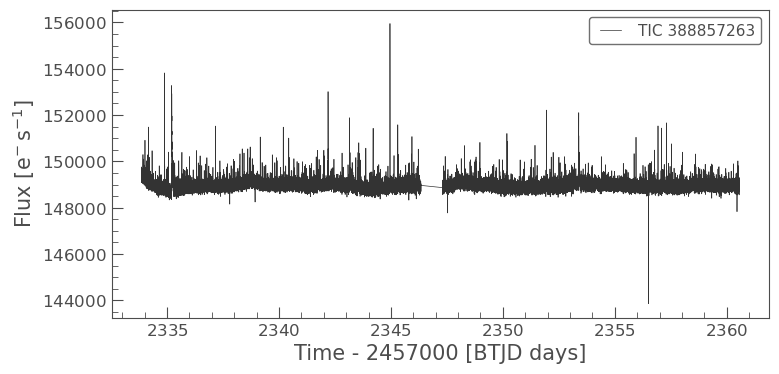

In [240]:
lightcurve.plot()

# Periodogram analysis

In [241]:
from astropy.timeseries import LombScargle

In [242]:
ls = LombScargle(lightcurve.time.value, lightcurve.flux.value, dy=lightcurve.flux_err.value,)
frequency, power = ls.autopower(
                        nyquist_factor=2)


best_frequency = frequency[np.argmax(power)]
y_fit = ls.model(lightcurve.time.value, best_frequency)

In [243]:
best_frequency

0.1460761971508668

In [244]:
lightcurve.time.value

array([2333.85831719, 2333.85854868, 2333.85878017, ..., 2360.55624915,
       2360.55648063, 2360.55671211])

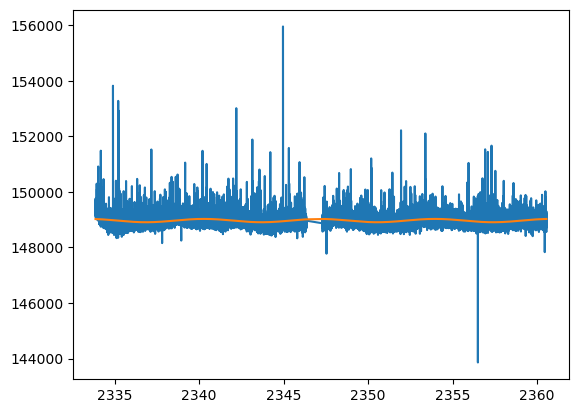

In [245]:
plt.plot(lightcurve.time.value, lightcurve.flux.value)
plt.plot(lightcurve.time.value, y_fit)
# plt.yscale('log')

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

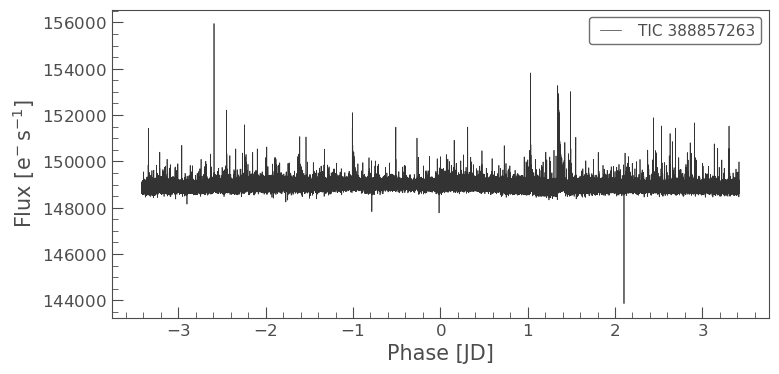

In [246]:
# for fun, we can fold at this period
lightcurve.fold(period=1/best_frequency).plot()

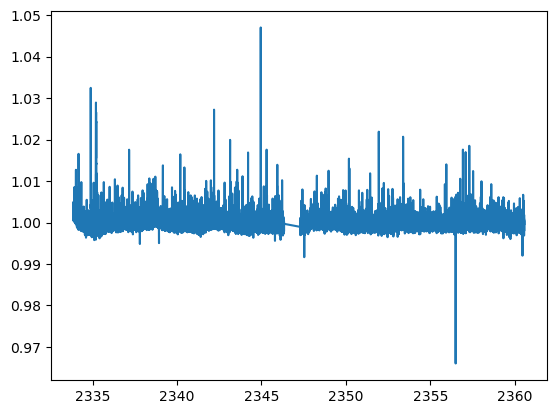

In [247]:
plt.plot(lightcurve.time.value, lightcurve.flux.value/y_fit)

In [248]:
cleaned_once = lightcurve.flux.value/y_fit

In [249]:
ls = LombScargle(lightcurve.time.value, cleaned_once)
frequency, power = ls.autopower(
                        nyquist_factor=2)


best_frequency = frequency[np.argmax(power)]
y_fit = ls.model(lightcurve.time.value, best_frequency)

In [250]:
ls.false_alarm_probability(power.max()) 

0.0

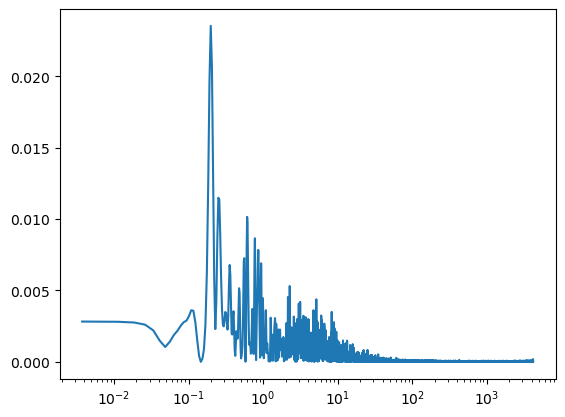

In [251]:
plt.plot(frequency, power)
plt.xscale('log')

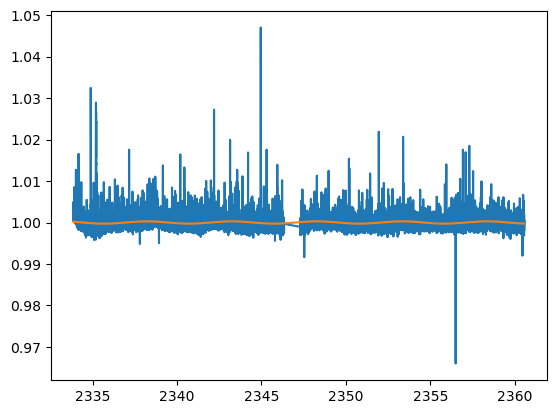

In [252]:
plt.plot(lightcurve.time.value, cleaned_once)
plt.plot(lightcurve.time.value, y_fit)


In [253]:
cleaned_twice = cleaned_once/y_fit

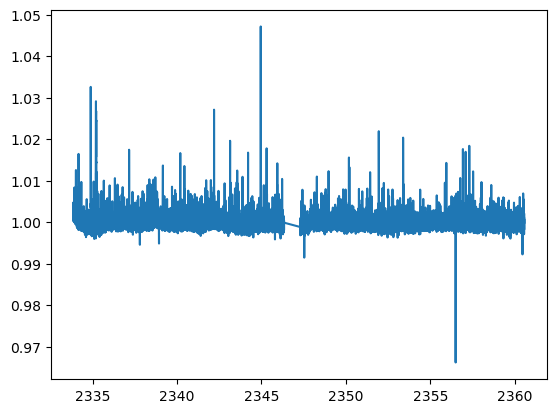

In [254]:
plt.plot(lightcurve.time.value,cleaned_twice)

In [255]:
ls = LombScargle(lightcurve.time.value, cleaned_twice)
frequency, power = ls.autopower(
                        nyquist_factor=2)


best_frequency = frequency[np.argmax(power)]
y_fit = ls.model(lightcurve.time.value, best_frequency)

In [256]:
ls.false_alarm_probability(power.max()) 

3.065993328564256e-255

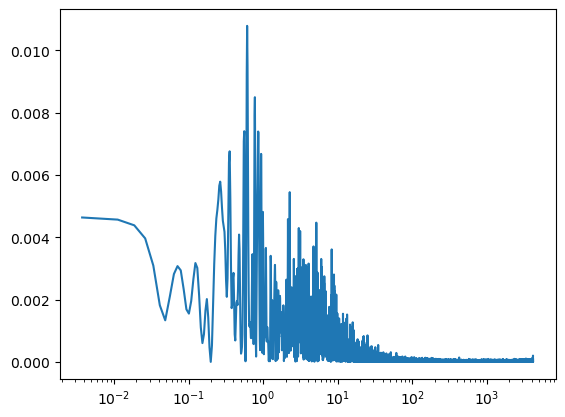

In [257]:
plt.plot(frequency, power)
plt.xscale('log')

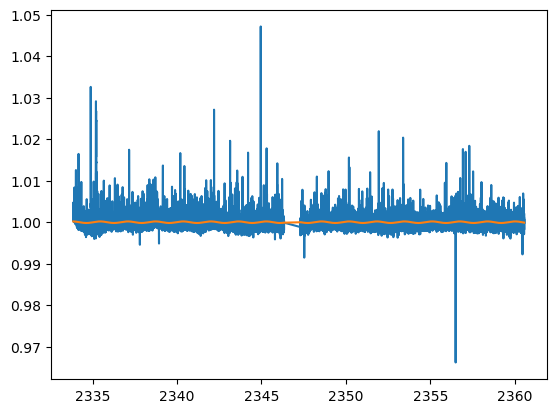

In [258]:
plt.plot(lightcurve.time.value, cleaned_twice)
plt.plot(lightcurve.time.value, y_fit)

In [259]:
cleaned_thrice = cleaned_twice / y_fit

In [260]:
ls = LombScargle(lightcurve.time.value, cleaned_thrice)
frequency, power = ls.autopower(
                        nyquist_factor=2)


best_frequency = frequency[np.argmax(power)]
y_fit = ls.model(lightcurve.time.value, best_frequency)

In [261]:
ls.false_alarm_probability(power.max()) 

1.0816202306824183e-183

In [262]:
# todo: check if standard deviation of residuals decreases with each step.

# Filtering

In [263]:
#todo: do the running mean
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian1DKernel, Box1DKernel, convolve


In [264]:
np.diff(lightcurve.time.value) * 1024

array([0.23704242, 0.23704242, 0.23704218, ..., 0.23703598, 0.2370355 ,
       0.2370355 ])

(0.95, 1.05)

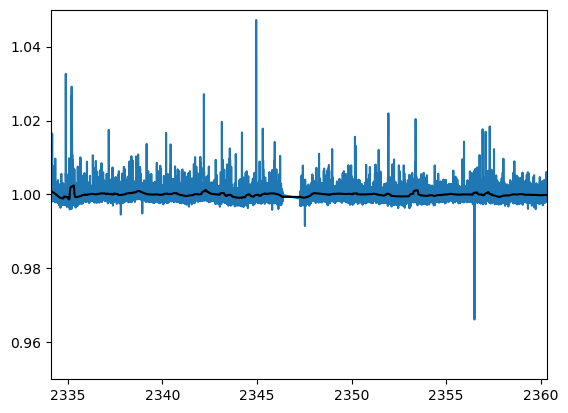

In [265]:
# global view
width = 1024
g = Box1DKernel(width=width)

z = convolve(cleaned_twice, g)

plt.plot(lightcurve.time.value, cleaned_twice)

dt = np.diff(lightcurve.time.value)[0]

plt.plot(lightcurve.time.value, z, color='black')
plt.xlim(lightcurve.time.value.min() + dt * width, lightcurve.time.value.max() - dt * width)

plt.ylim(0.95, 1.05)

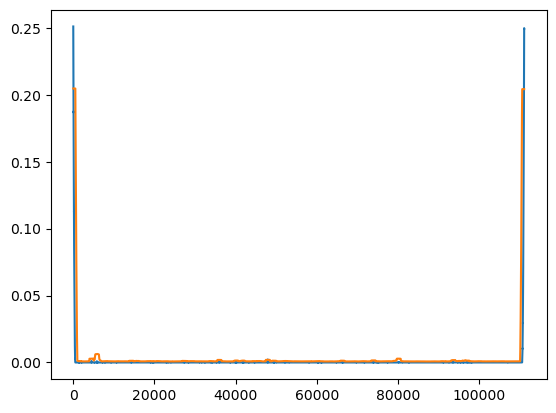

In [266]:
plt.plot(np.square(cleaned_twice - z))

cleanthing = np.square(cleaned_twice - z)
z2 = convolve(cleanthing, g)

plt.plot(np.sqrt(z2))

In [267]:
# check the rolling average approaches

In [268]:
np.sqrt(z)[200]

0.8349345247375174

In [269]:
s = pd.Series(cleaned_twice)
s.rolling(68).std()

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
111050    0.001021
111051    0.001021
111052    0.001026
111053    0.001037
111054    0.001030
Length: 111055, dtype: float64

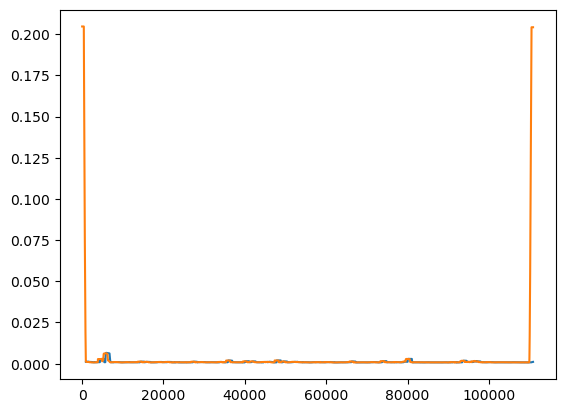

In [270]:
plt.plot(s.rolling(1024).std()[100:-100].values)
plt.plot(np.sqrt(z2[100:-100]))
# good enough to do the convolution without introducing a new dependency!

# Flare candidate detection

(0.95, 1.05)

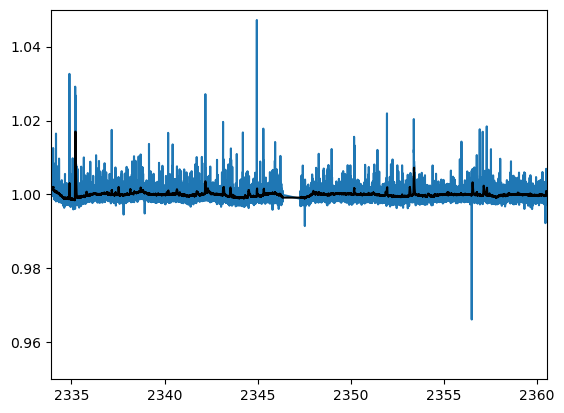

In [271]:
# local view
width = 128
g = Box1DKernel(width=width)

z = convolve(cleaned_twice, g)

plt.plot(lightcurve.time.value, cleaned_twice)

dt = np.diff(lightcurve.time.value)[0]

plt.plot(lightcurve.time.value, z, color='black')
plt.xlim(lightcurve.time.value.min() + dt * width, lightcurve.time.value.max() - dt * width)

plt.ylim(0.95, 1.05)

In [272]:
# are there 3 data points greater than 3 sigma?

(0.85, 1.25)

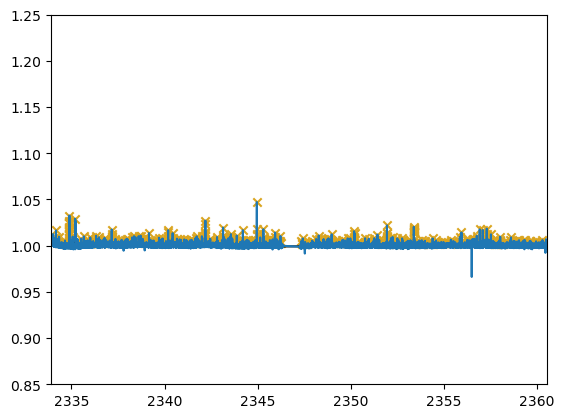

In [273]:
sigma =  np.sqrt(z2)

plt.plot(lightcurve.time.value, z, color='black')
plt.xlim(lightcurve.time.value.min() + dt * width, lightcurve.time.value.max() - dt * width)



mask = cleaned_twice > z + 3 * sigma

plt.scatter(lightcurve.time.value[mask], cleaned_twice[mask], marker='x', color='goldenrod')



plt.plot(lightcurve.time.value, cleaned_twice)
plt.ylim(0.85, 1.25)

In [358]:
lightcurve.time

<Time object: scale='tdb' format='btjd' value=[2333.85831719 2333.85854868 2333.85878017 ... 2360.55624915 2360.55648063
 2360.55671211]>

In [274]:
# see whether there are consecutive times!

ticker = 0
ticker_arr = []
for m in mask:
    if m:
        ticker += 1
    else:
        ticker = 0
    ticker_arr += [ticker]

In [275]:
other_mask = np.array(ticker_arr) >= 3

(0.85, 1.25)

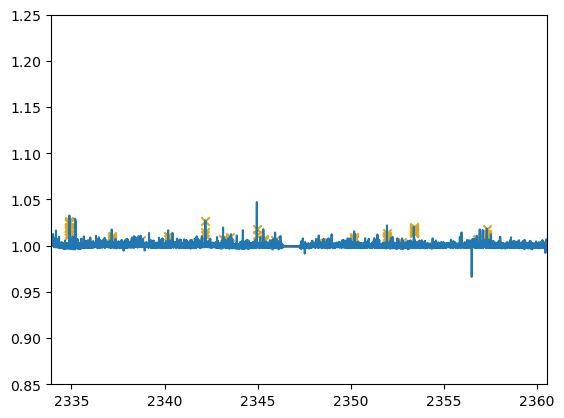

In [276]:
plt.plot(lightcurve.time.value, z, color='black')
plt.xlim(lightcurve.time.value.min() + dt * width, lightcurve.time.value.max() - dt * width)


plt.scatter(lightcurve.time.value[other_mask], cleaned_twice[other_mask], marker='x', color='goldenrod')



plt.plot(lightcurve.time.value, cleaned_twice)
plt.ylim(0.85, 1.25)
# plt.xlim(1336.2, 1336.4)

# Write timestamps

In [341]:
# need to convert these back

formatted_days = lightcurve.time.value[other_mask] + 2457000 # these are in BTJD days

np.save(f'flare_timestamps_{star}.npy', formatted_days)

In [342]:
lightcurve.time

<Time object: scale='tdb' format='btjd' value=[2333.85831719 2333.85854868 2333.85878017 ... 2360.55624915 2360.55648063
 2360.55671211]>

In [363]:
lightkurve.btjd_to_astropy_time(2360.55671211).mjd

array([59360.05671211])

In [343]:
from astropy import Time

ImportError: cannot import name 'Time' from 'astropy' (/Users/arjunsavel/opt/miniconda3/envs/uhj_magnet/lib/python3.10/site-packages/astropy/__init__.py)

In [344]:
sometimes

NameError: name 'sometimes' is not defined

In [355]:
t = Time(2333.85831719 + 2457000, scale='tdb', format='btjd')

In [356]:
t.mjd

2516333.35831719

In [347]:
btjd

NameError: name 'btjd' is not defined

In [348]:
obs_table = Observations.query_object("Proxima Centauri",radius="10 arcsec")
#                                                    t_max=[t.mjd - 1, t.mjd + 1],
#                                                    t_min=[t.mjd - 1, t.mjd + 1])

In [322]:
times = obs_table[obs_table['project']=='HST']['t_min']


In [374]:
for time in times:
    t = Time(time, format='mjd')
    print(t.btjd)

-8351.170021045504
-8351.168250258466
-8351.165599749205
-8351.159268776979
-8351.157173869575
-8351.155078962165
-8351.151166878832
-8351.148192388087
-8351.14213918207
-8351.140044193642
-8351.137903070956
-8329.588609048866
-8329.587139060439
-8329.58456965071
-8329.57823867849
-8329.57614377108
-8329.573609048863
-8329.569720159965
-8329.567023354412
-8329.56534507895
-8341.650449283436
-8341.648979376027
-8341.646409862136
-8341.640078878341
-8341.637984051948
-8341.635889063527
-8341.631977061204
-8341.629280267227
-8341.622949283425
-8294.641919182563
-8294.640437666354
-8294.638539552934
-8294.635993256632
-8294.634766370064
-8294.633122886267
-8294.63117844182
-8294.62923396265
-8285.67511367301
-8285.673632145235
-8285.671734043384
-8285.66918774709
-8285.667960848938
-8285.666317376717
-8285.664372966998
-8285.662428441532
-8275.692382145446
-8275.69090066396
-8275.68900256211
-8275.686456265816
-8275.684812747299
-8275.683169182485
-8275.681224738037
-8275.679280374614
-826

In [366]:
t = Time(59631.89107542824, format='mjd')

In [367]:
t.btjd

2632.3918761833247

In [315]:
np.unique(obs_table['project'])

AIS
HAP
HLA
HST
--
TESS
hlsp_starcat


In [309]:
obs_table

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID,objID1,distance
str1,int64,str1,str1,str1,float64,float64,float64,float64,float64,str1,str1,float64,float64,str1,str1,float64,str1,str1,str1,str1,str1,int64,str1,str1,str1,str1,str1,bool,float64,str1,str1,str1,str1,float64


In [338]:
some_flares = np.load('flare_timestamps_Proxima Centauri.npy')

In [339]:
some_flares

array([2334.89190495, 2334.89213644, 2334.89236793, 2334.89259941,
       2334.8928309 , 2334.89306239, 2334.89329387, 2334.89352536,
       2334.89375684, 2334.89398833, 2334.89421982, 2334.8944513 ,
       2335.80697122, 2335.80720271, 2337.16463874, 2337.16487023,
       2337.16510171, 2337.1653332 , 2337.16556469, 2338.36188498,
       2338.71675297, 2340.19478962, 2340.19502111, 2341.72814918,
       2342.19389743, 2342.19412892, 2342.1943604 , 2343.14483803,
       2343.17238474, 2343.53280673, 2344.95852092, 2344.9587524 ,
       2345.32519232, 2345.3254238 , 2345.32565528, 2345.9251997 ,
       2348.28216411, 2348.55161016, 2348.80346349, 2350.18124871,
       2350.18148019, 2350.18171168, 2350.18194316, 2351.94792279,
       2351.94815427, 2351.94838575, 2351.94861723, 2351.94884872,
       2351.9490802 , 2352.76019378, 2353.38774155, 2353.38797304,
       2353.38820452, 2353.388436  , 2353.38866748, 2353.38889896,
       2353.38913045, 2353.38936193, 2353.38959341, 2353.38982

In [364]:
for flare in some_flares:
    print(lightkurve.btjd_to_astropy_time(flare).mjd)

[59334.39190495]
[59334.39213644]
[59334.39236793]
[59334.39259941]
[59334.3928309]
[59334.39306239]
[59334.39329387]
[59334.39352536]
[59334.39375684]
[59334.39398833]
[59334.39421982]
[59334.3944513]
[59335.30697122]
[59335.30720271]
[59336.66463874]
[59336.66487023]
[59336.66510171]
[59336.6653332]
[59336.66556469]
[59337.86188498]
[59338.21675297]
[59339.69478962]
[59339.69502111]
[59341.22814918]
[59341.69389743]
[59341.69412892]
[59341.6943604]
[59342.64483803]
[59342.67238474]
[59343.03280673]
[59344.45852092]
[59344.4587524]
[59344.82519232]
[59344.8254238]
[59344.82565528]
[59345.4251997]
[59347.78216411]
[59348.05161016]
[59348.30346349]
[59349.68124871]
[59349.68148019]
[59349.68171168]
[59349.68194316]
[59351.44792279]
[59351.44815427]
[59351.44838575]
[59351.44861723]
[59351.44884872]
[59351.4490802]
[59352.26019378]
[59352.88774155]
[59352.88797304]
[59352.88820452]
[59352.888436]
[59352.88866748]
[59352.88889896]
[59352.88913045]
[59352.88936193]
[59352.88959341]
[59352.

In [17]:
import json
import ast
import sys
import os
import json
import pprint
import urllib.request
from urllib.parse import quote as urlencode

import numpy as np
import requests
from astropy.table import Table
from astroquery.mast import Observations

In [26]:
object_of_interest = 'Proxima Centauri'

resolver_request = {'service':'Mast.Name.Lookup',
                     'params':{'input':object_of_interest,
                               'format':'json'},
                     }

# encoding the request as a json string
req_string = json.dumps(resolver_request)
req_string = urlencode(req_string)

In [27]:
# retrieve our system's Python version for the request. 
version = ".".join(map(str, sys.version_info[:3]))

# create HTTP Header Variables
headers = {"Content-type": "application/x-www-form-urlencoded",
           "Accept": "text/plain",
           "User-agent":"python-requests/"+version}


In [28]:
# base API url
request_url='https://mast.stsci.edu/api/v0/invoke'    

# perform the HTTP request
resp = requests.post(request_url, data="request="+req_string, headers=headers)

In [29]:
resp.json()

{'resolvedCoordinate': [{'searchString': 'proxima centauri',
   'resolver': 'SIMBADCFA',
   'cached': False,
   'resolverTime': 190,
   'searchRadius': -1.0,
   'canonicalName': 'NAME Proxima Centauri',
   'ra': 217.4289422216058,
   'decl': -62.6794901890756,
   'objectType': 'Eruptive*'}],
 'status': ''}

# Exercises
1. Try this for another star.
2. Add a spline-fit detrending step to the flare-detection pipeline.
3. Perform injection/recovery tests in the flare-detection pipeline.
4. Identify "outburst flares," as described by Günther et al. 2020: "... iterate through all flare events sorted in time. For a given flare, if there is no other candidate peak one hour before or three hours after the event, the outburst is labeled as containing only this single flare. When there are other flares following, the outburst epoch gets expanded accordingly. As a result, outburst epochs span from 1 hr before their earliest flare peak to 3 hr after their latest flare peak."
4. Loop this pipeline over many stars. Try to construct a flare rate vs. stellar rotation period diagram for all known M dwarf exoplanet hosts.
5. Connect this to the HST timestamps for a single M dwarf (e.g., Proxima Centauri) — are there any overlaps?
6. Estimate the energy associated with an individual flare.

# Additional Resources
- Give a few flares papers
- give a few TESS papers
- convolution resources
- periodogram resources


# About this Notebook

**Author**: Arjun B. Savel (asavel@umd.edu).

**Last updated**: 2022-08-14

# Citations
If you use `astropy`, `lightkurve`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citing `astropy`,
`lightkurve`, and `numpy`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](https://docs.lightkurve.org/about/citing.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)

[Top of Page](#top)<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>
